# Debye Shielding

## Theory
The Debye Shielding is a fundamental property of a plasma. This property concerns the ability of a plasma to shield electric potentials applied to it.

If for example, a positive electric charge is placed inside a plasma, electrons/protons will rapidly drift towards/away from that charge. If the plasma temperature is 0, the amount of charge surrounding the initial charge would make the initial electric potential to be shielded at all places.

However, if the plasma has a certain temperature, electrons can get out of potentials that are of the order of their thermal energy, and the charge does not perfectly shield the initial potential for all distances, but only for distances longer than what is called the Debye Length.

In Chen [1] a complete derivation of the formula for the Debye Length is given in chapter one.

$\lambda_D=\left(\frac{\epsilon_0KT_e}{ne^2}\right)$

## Setup

In order to study this property we will study a setup with an external charge distribution (analogous to a cylinder) in a 2D plasma. Inside the cylinder the electric field is linear, and outside it decays with 1/r. 

A lineout in the x direction is shown in the picture. The prediction is that negative charge will accumulate near the external charge in order to shield the rest of the plasma. The decay will be regulated by the Debye length.

<img src="image.png" width="800">

### Low Temperature ($\lambda_D = 1$)

In [1]:
import em2d
import numpy
from math import sqrt,atan2,cos,sin
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

# Simulation time 
tmax = 10

# Number of cells
nx  = [256,256]

# Simulation box size
box = [12,12]

# Time step  Courant Condition: dt < 1 / ( 1/dx^2 + 1/dy^2 )    
dt = 0.03 

## Background plasma

# Particles per cell
ppc = [3,3]

dens=em2d.Density( type = "uniform")

#Density of the initial plasma surrounding the charged cylinder
#In this notebook we select the density to be 0.2 so that kT/n ~ 1 without the need 
#of relativistic electron velocities (n=1 requires velocities of c so the Debye length is 1)

dens.n=0.2

# Use a step density profile
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[0.0,0,0],uth=[0.1,0.1,0.1])

# Initialize simulation
sim = em2d.Simulation( nx, box, dt, species = (electrons) )

#Radius of the cylinder 
a=0.2 

#Charge density inside the cylinder (stationary charge)
n_inside=2.0

#Electric Field magnitude
def mod_r(r):
    if r<a:
        return n_inside/2.*r
    else:
        return n_inside/2*a**2/r
    
#No external magnetic field
def ext_B1(x,y,t):
    return [0.0,0.0,0.0]

#Centering the electric field in the center of the box
def ext_E1(x,y,t):
    r=sqrt((x-6)**2+(y-6)**2)
    phi=atan2(x-6,y-6)
    return [mod_r(r)*sin(phi),mod_r(r)*cos(phi),0]


ex=em2d.Ext_Field(sim,ext_E=ext_E1,ext_B=ext_B1)

def itera():
    sim.current.zero()
    species=sim.get_species()
    for spec in species:
        spec.advance(sim)

    sim.current.update()
    sim.emf.advance(sim)
    ex.update_ext(sim)
    sim.advance()
itera()

### Let's check the initial electric field.

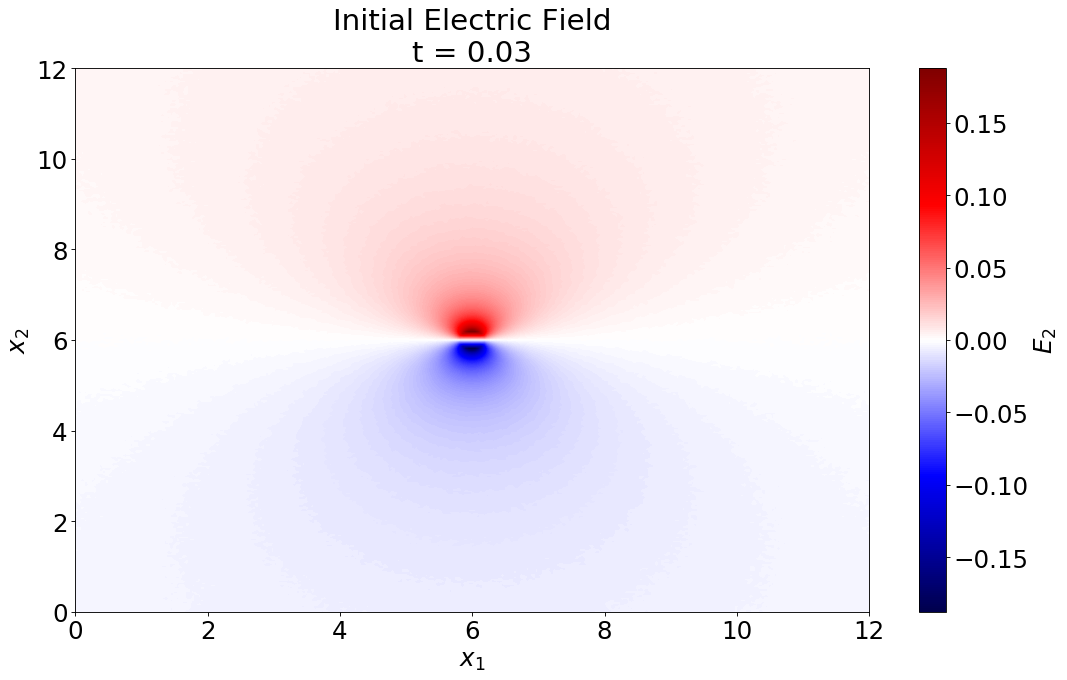

In [2]:
plt.rcParams.update({'font.size': 22})
range = [[0,sim.box[0]],[0,sim.box[1]]]
fig=pl.figure(figsize=(16, 9), dpi=80)
pl.imshow( sim.emf.E_part[:,:,1], interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto', cmap = 'seismic')

pl.colorbar().set_label('$E_2$')
pl.xlabel("$x_1$")
pl.ylabel("$x_2$")
pl.title("Initial Electric Field\nt = {:g}".format(sim.t))
pl.show()

### Now it's time to make the system evolve in time.

In [3]:
while sim.t < 10:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    itera()

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


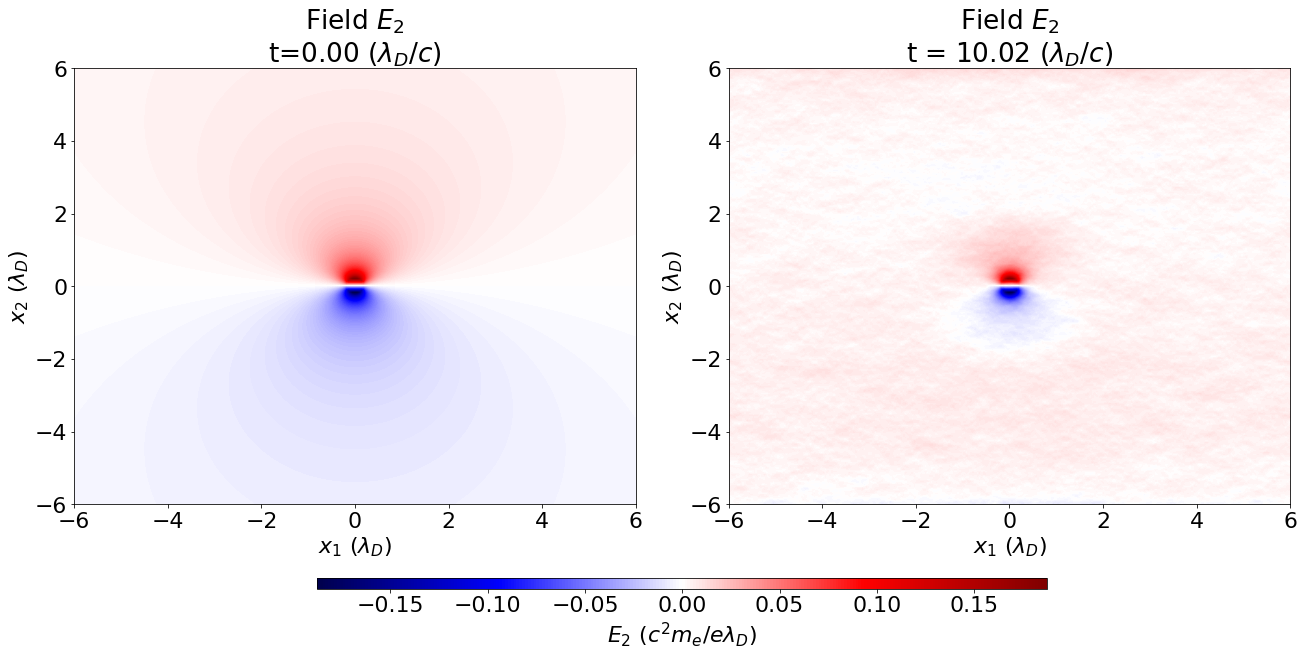

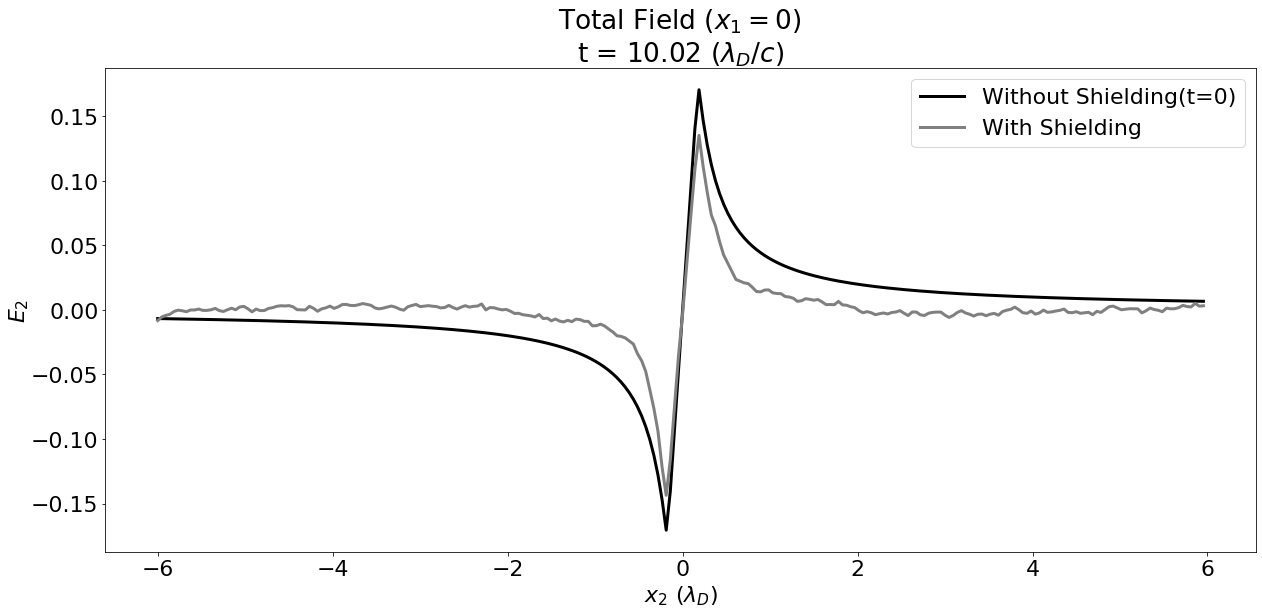

In [4]:
fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(18,9))


range=[[-6,6],[-6,6]]
ax1 = axs.flat[0]#plt.subplot2grid((2, 2), (0, 0),colspan=1)
result1=ax1.imshow( sim.emf.E_part[:,:,1]-sim.emf.E_buf[:,:,1], interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto', cmap = 'seismic')
#pl.colorbar(result1,shrink=1,cmap='seismic',ax=ax1,label="$E_2~(c^2m_e/e\lambda_D)$")
#pl.colorbar().set_label('$E_2$')
ax1.set_xlabel("$x_1~(\lambda_D)$")
ax1.set_ylabel("$x_2~(\lambda_D)$")
ax1.set_title("Field $E_2$\nt=0.00 $(\lambda_D/c)$")
#pl.show()

#Second Plot (middle) - Total Field
ax2 = axs.flat[1]#plt.subplot2grid((2, 2), (0, 1),colspan=1)


result2=ax2.imshow( sim.emf.E_part[:,:,1], interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto', cmap = 'seismic')


ax2.set_xlabel("$x_1~(\lambda_D)$")
ax2.set_ylabel("$x_2~(\lambda_D)$")
ax2.set_title("Field $E_2$\nt = {:g} $(\lambda_D/c)$".format(sim.t))
fig.colorbar(result1, ax=axs[:], shrink=0.6, location='bottom',label="$E_2~(c^2m_e/e\lambda_D)$")

#Third plot (down) - Lineout
fig, ax3 = plt.subplots(1, 1, constrained_layout=True,figsize=(18,9))
ax3.plot(np.arange(0,nx[1])*box[1]/nx[1]-6,sim.emf.E_part[1:-2,127,1]-sim.emf.E_buf[1:-2,127,1],color='black',linewidth=3,label='Without Shielding(t=0)')
ax3.plot(np.arange(0,nx[1])*box[1]/nx[1]-6,sim.emf.E_part[1:-2,127,1],color='gray',linewidth=3,label='With Shielding')


ax3.set_xlabel("$x_2~(\lambda_D)$")
ax3.set_ylabel("$E_2~\frac{c^2m_e}{c\lambda_D}$",labelpad=0)
ax3.set_title("Total Field ($x_1=0$) \nt = {:g} $(\lambda_D/c)$".format(sim.t))
ax3.legend()

plt.tight_layout()





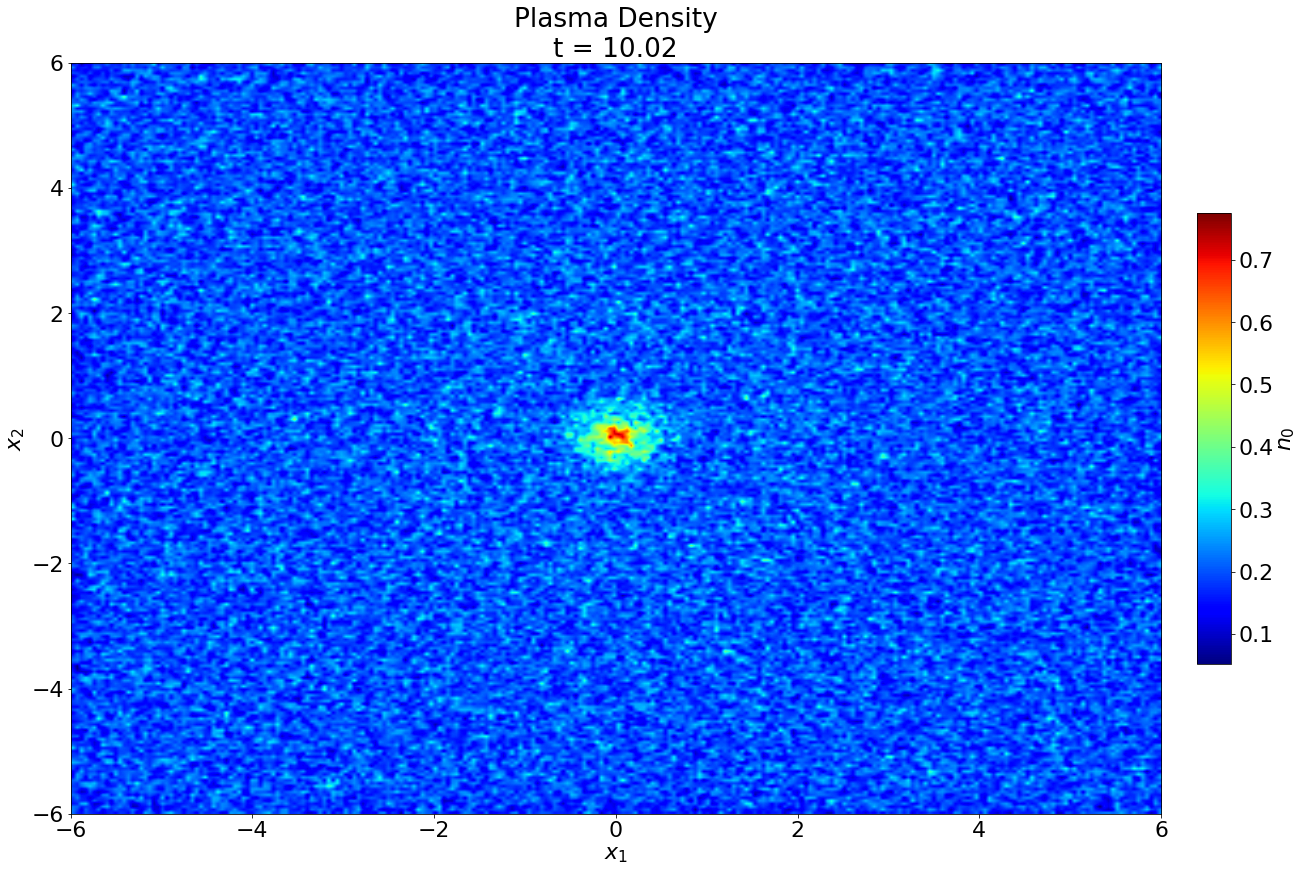

In [11]:
#Third Plot (upper right) - Plasma Density

fig, ax3 = plt.subplots(1, 1, constrained_layout=True,figsize=(18,12))
a=ax3.imshow( np.abs(electrons.charge()), interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto', cmap = 'jet')
fig.colorbar(a, ax=ax3, shrink=0.6, location='right',label="$n_0$")
ax3.set_xlabel("$x_1$")
ax3.set_ylabel("$x_2$")
ax3.set_title("Plasma Density\nt = {:g}".format(sim.t))
pl.show()

### Higher Temperature ($\lambda_D = \sqrt{3}$, for example)

In order to get a higher temperature, you must copy the cells above and run a new simulation. In order to get a different Debye length, uth or n_inside should be changed. Can you see the difference between the final electron distributions? What should happen if $\lambda_D>>6=L$ (length of the box)? Is it still a plasma? Test and find out!